In [1]:
from keras.models import load_model
from data_import import analyse_data, prepare_data
import numpy as np
from lstm import build_lstm
import h5py
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
from sklearn.preprocessing import MinMaxScaler
import pickle


def generate_error(model, X, Y, scaler):
    Y_hat = np.empty((len(X), Y.shape[1]))

    for x in range(len(X)):
        Y_hat[x] = model.predict(np.array([X[x,:,:]]), batch_size=1)

    Y_unscaled = scaler.inverse_transform(Y)
    Y_hat_unscaled = scaler.inverse_transform(Y_hat)
    return  Y_unscaled - Y_hat_unscaled



Using TensorFlow backend.


In [2]:
    ######Load Data

    ##VALidation
    with h5py.File('Data/Infocom/Normal/data.h5', 'r') as hf:
        x_val = hf['x_val'][:]
        y_val = hf['y_val'][:]

    with open('Data/Infocom/Normal/scaler.pkl', 'rb') as pkfile:
        scaler = pickle.load(pkfile)

    ###TEST
    with h5py.File('Data/Infocom/Attack/data.h5', 'r') as hf:
        x_test = hf['x_test'][:]
        y_test = hf['y_test'][:]

    # with open('Data/Attack/scaler.pkl', 'rb') as pkfile:
    #     scaler_test = pickle.load(pkfile)

In [3]:
model = load_model('Data/Infocom/my_model.h5')

In [4]:
p_model = build_lstm((x_val.shape[1], x_val.shape[2]), 1, [50, 50])

In [5]:
model.save_weights('Data/Infocom/weights.h5')

In [6]:
p_model.load_weights('Data/Infocom/weights.h5')

In [7]:
errors = generate_error(p_model, x_val, y_val, scaler)

In [8]:
mean = np.mean(errors, axis=0)
var = np.var(errors, axis=0)
cov = np.cov(errors, rowvar=False)
mvn = multivariate_normal(mean=mean, cov=cov, allow_singular = True)

In [9]:
errors_p = generate_error(p_model, x_test, y_test, scaler)

In [10]:
with open('Data/Infocom/Attack/raw_data.pkl', 'rb') as pkfile:
    raw_data = pickle.load(pkfile)

In [14]:
len(raw_data['time_stamps'])

719

In [15]:
len(errors_p)

599

In [16]:
len(raw_data['entropy'])

719

In [74]:
time = raw_data['time_stamps'][-599:]
time = (time - time[0])/60
entropy = raw_data['entropy'][-599:]
time


array([   0.        ,    0.5       ,    1.        ,    1.5       ,
          2.        ,    2.5       ,    3.        ,    3.5       ,
          4.        ,    4.5       ,    5.        ,    5.5       ,
          6.        ,    6.5       ,    7.        ,    7.5       ,
          8.        ,    8.5       ,    9.        ,    9.5       ,
         10.        ,   10.5       ,   11.        ,   11.5       ,
         12.        ,   12.5       ,   13.        ,   13.5       ,
         14.        ,   14.5       ,   15.        ,   15.5       ,
         16.        ,   16.5       ,   17.        ,   17.5       ,
         18.        ,   18.5       ,   19.        ,   19.5       ,
         20.        ,   20.5       ,   21.        ,   21.5       ,
         22.        ,   22.5       ,   23.        ,   23.5       ,
         24.        ,   24.5       ,   25.        ,   25.5       ,
         26.        ,   26.5       ,   27.        ,   27.5       ,
         28.        ,   28.5       ,   29.        ,   29.5    

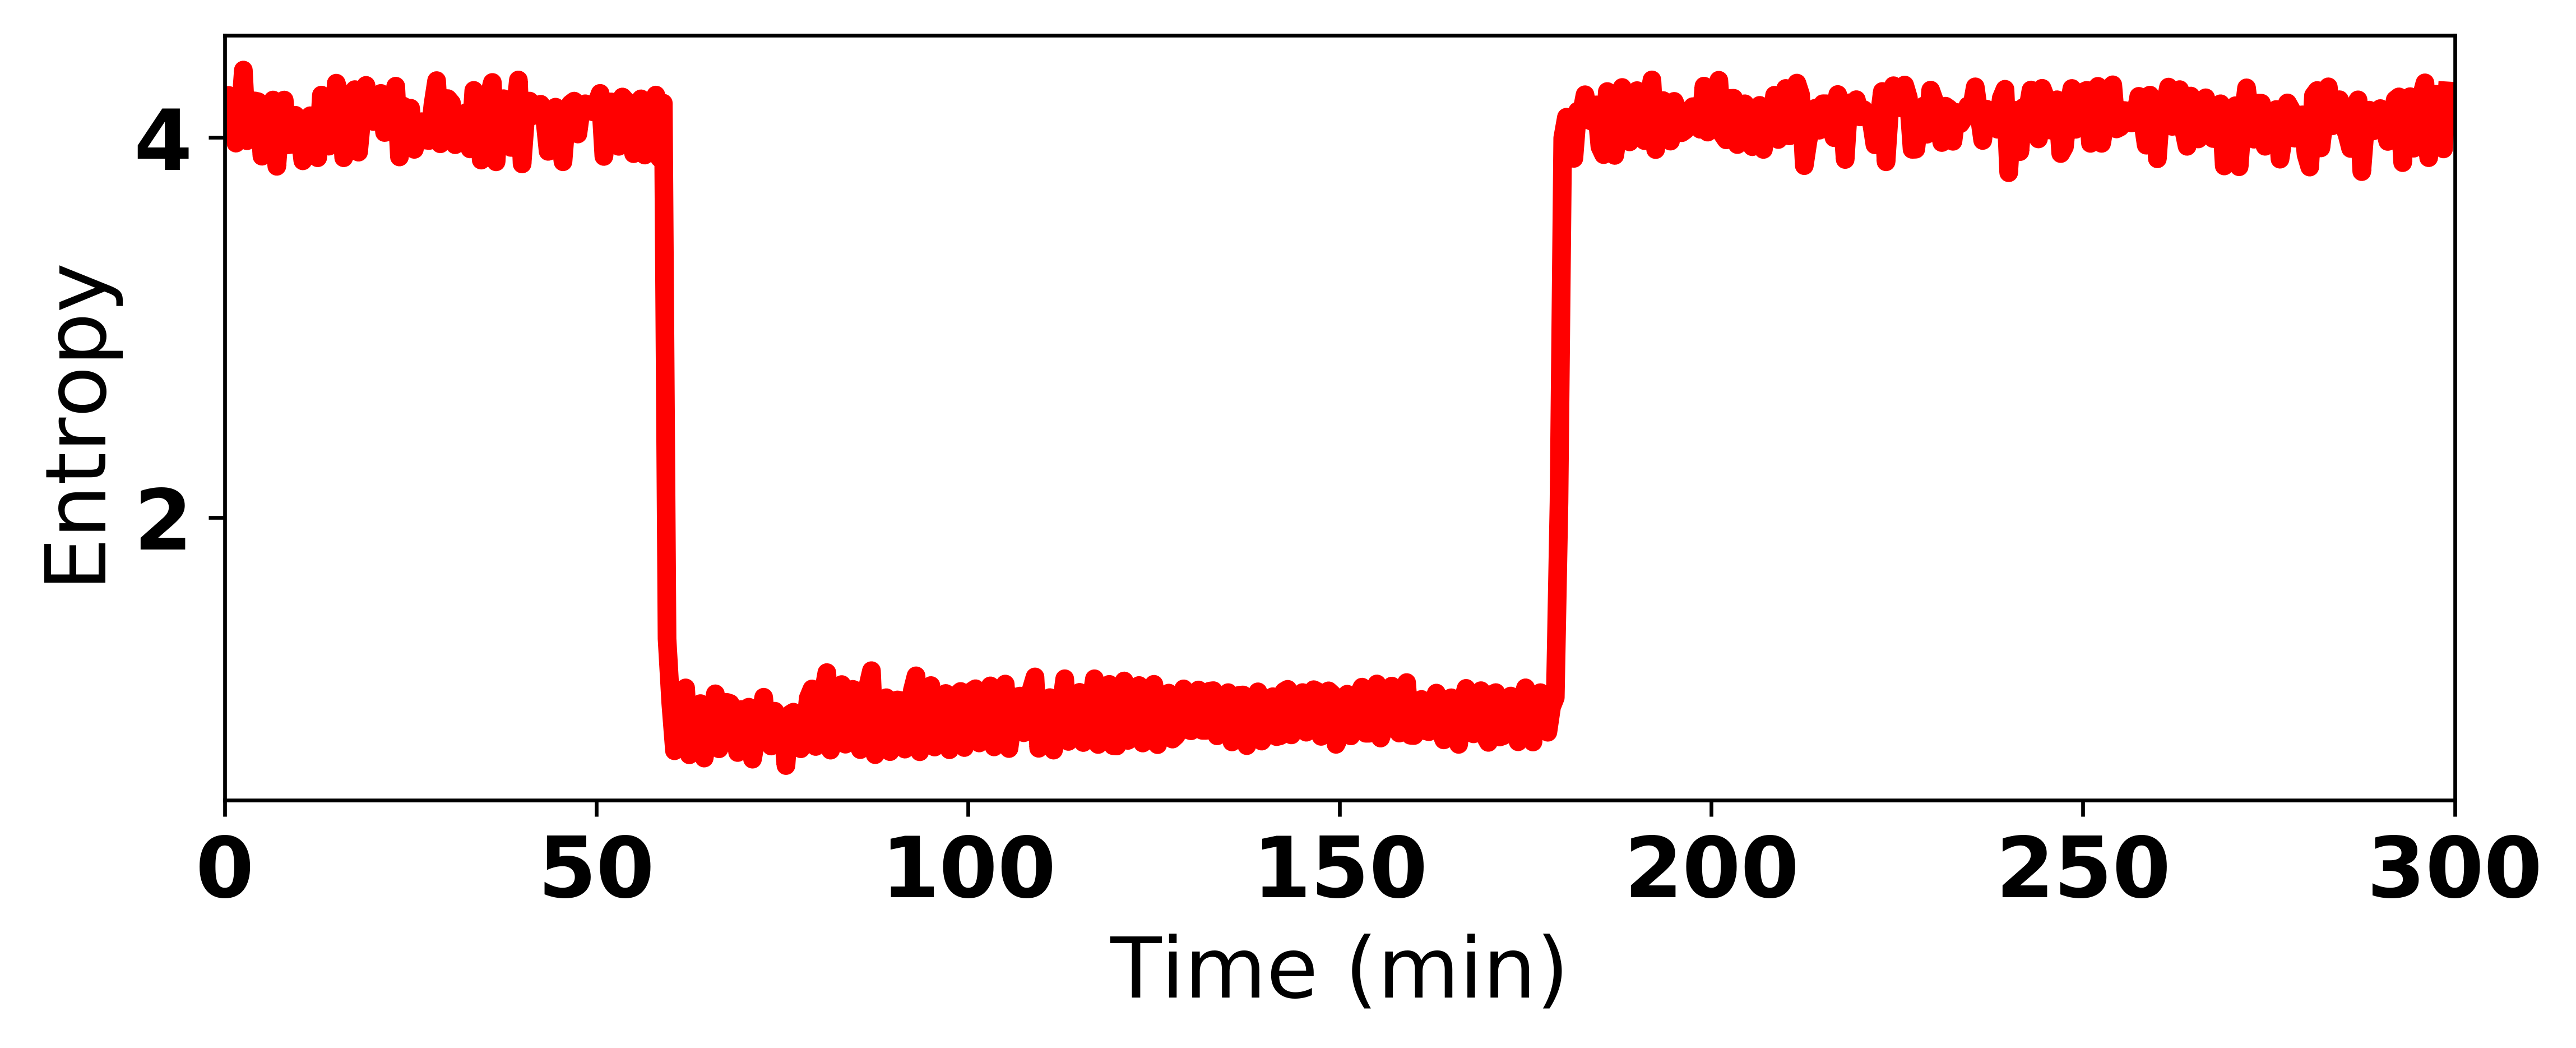

In [109]:
from matplotlib.ticker import NullFormatter

font = {'family' : 'DejaVu Sans',
        'size'   : 18}

plt.rc('font', **font)

plt.figure(1)
plt.figure(num=None, figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
ax1 = plt.subplot(211)
plt.xlabel('Time (min)')
plt.ylabel('Entropy')
plt.plot(time, entropy, 'r', linewidth=4.0)
plt.gca().set_xlim(xmin=0, xmax=300)
plt.tight_layout()
plt.savefig('Data/Infocom/entropy.png')
plt.show()



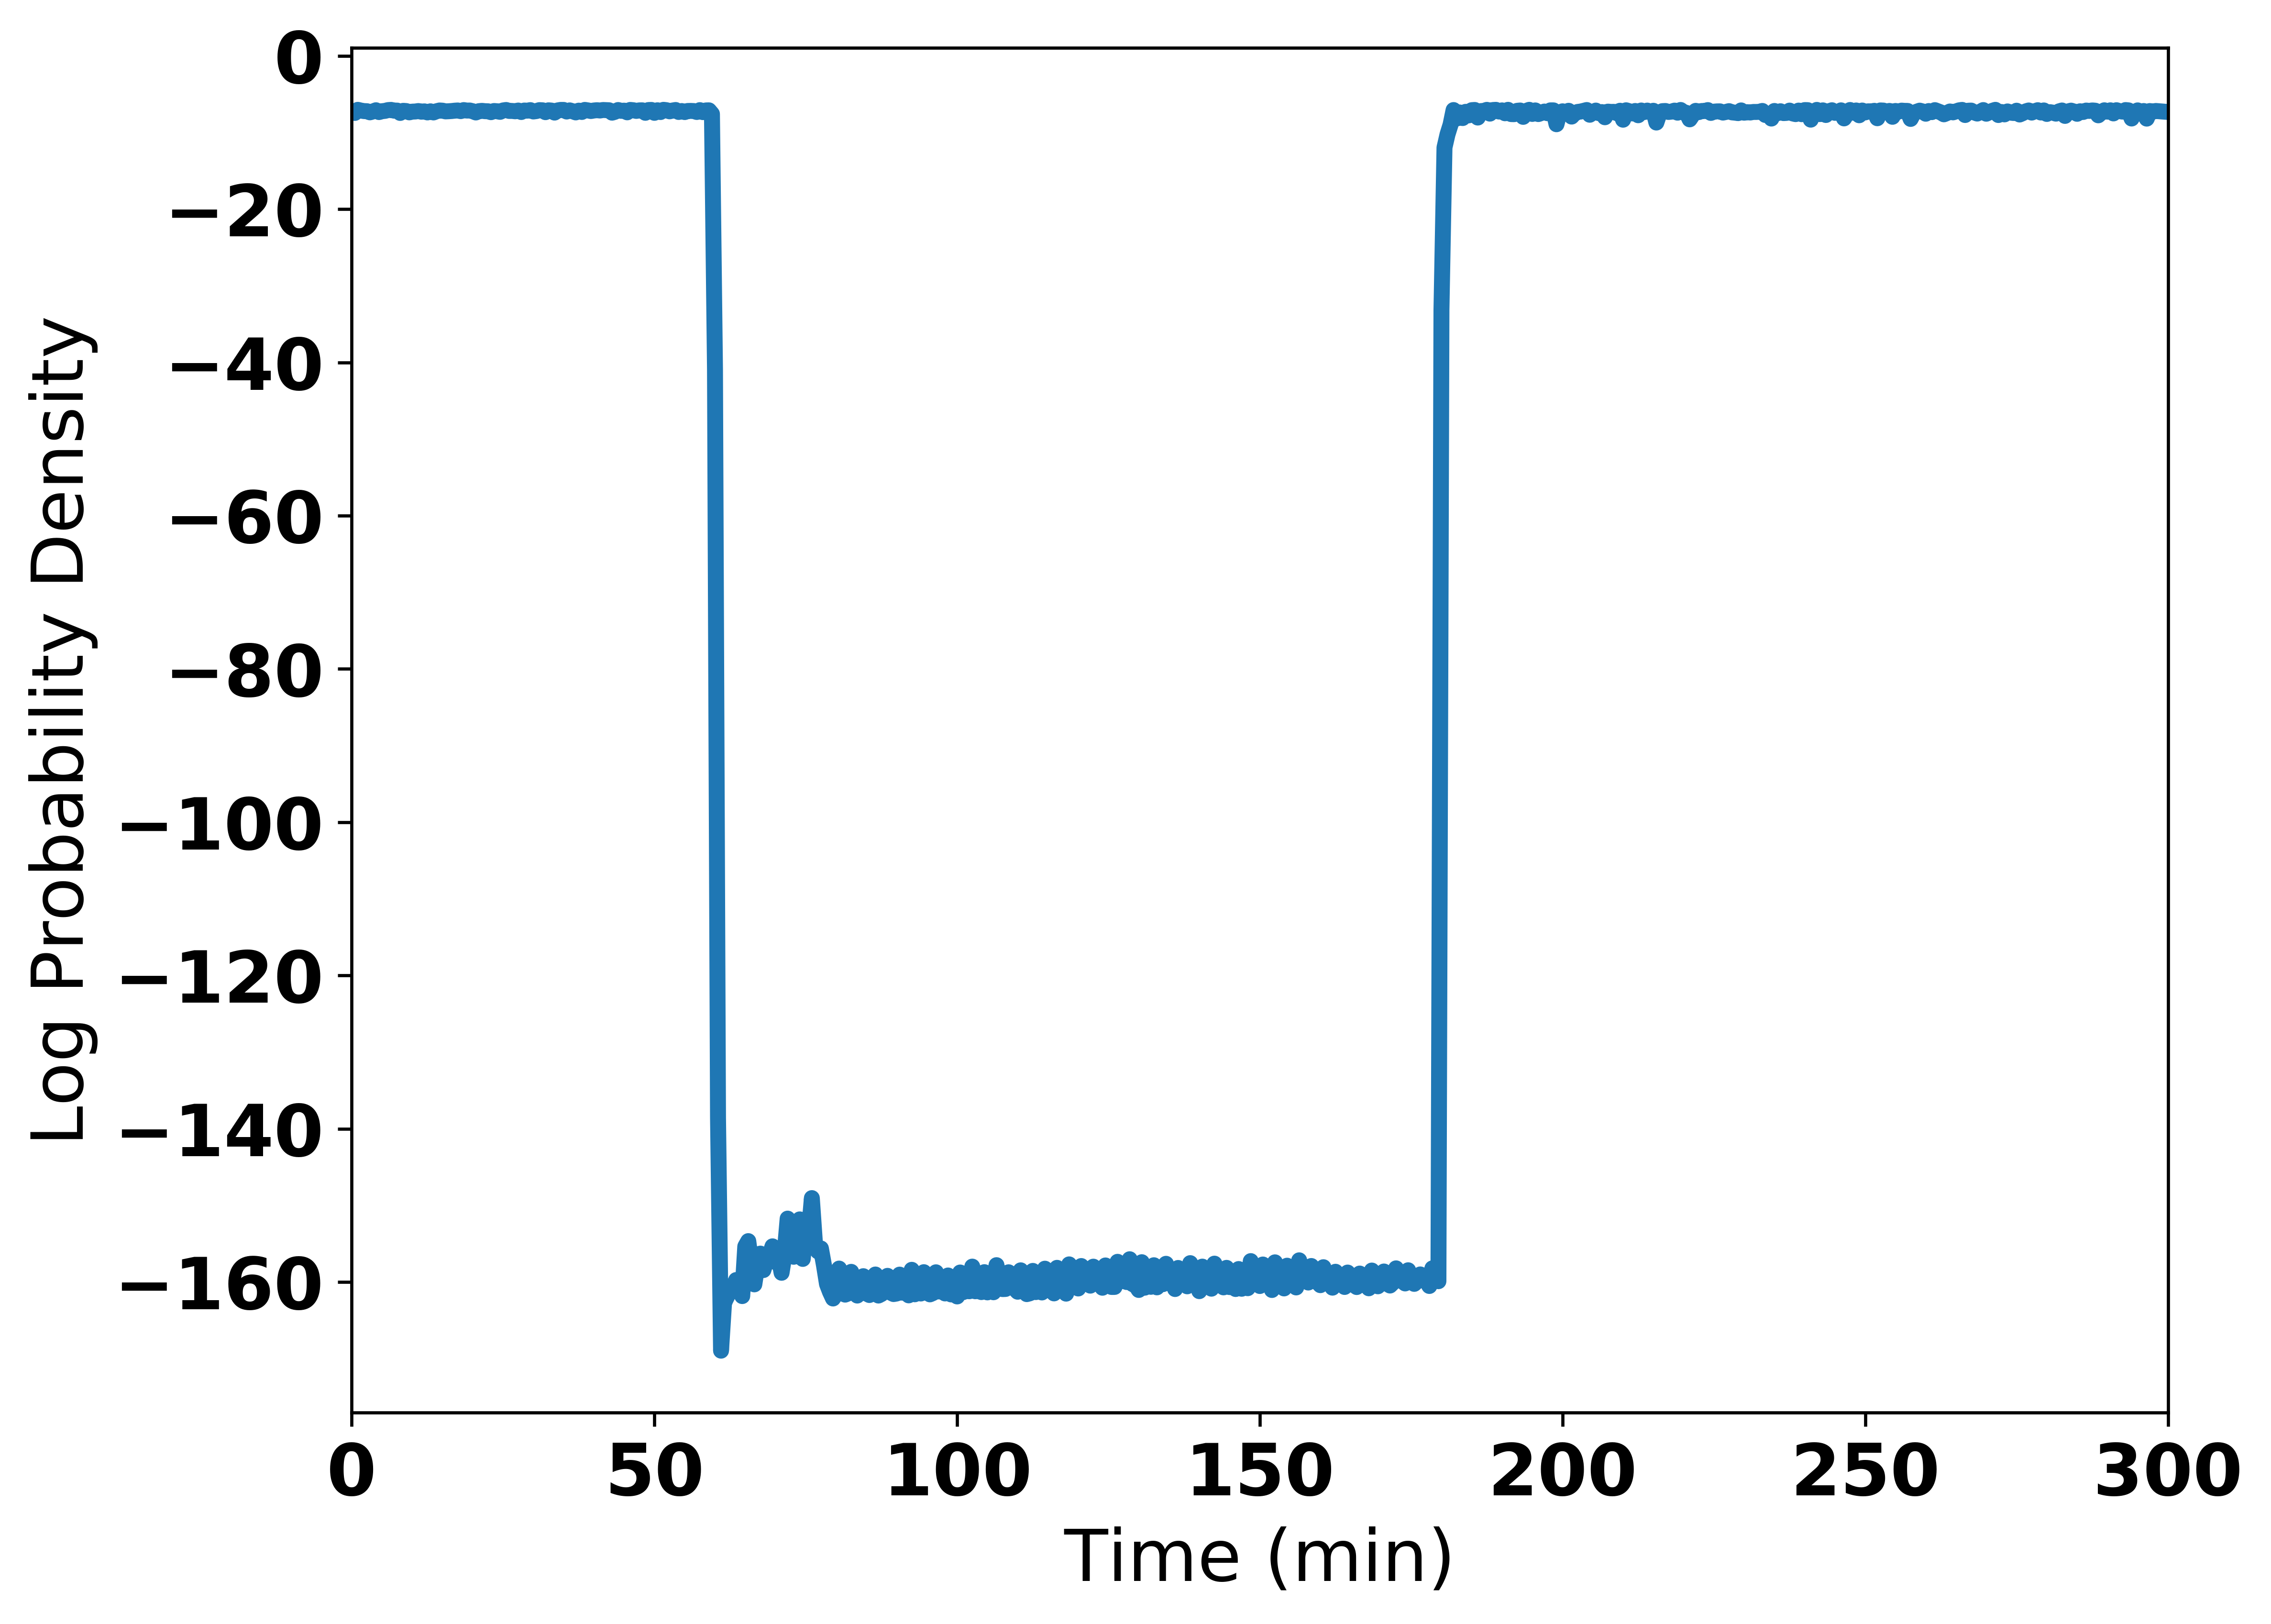

In [110]:
plt.figure(2)
plt.figure(num=None, figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
plt.xlabel('Time (min)')
plt.ylabel('Log Probability Density')

plt.plot(time, np.log10(mvn.pdf(errors_p)), linewidth=4.0)
plt.tight_layout()
plt.gca().set_xlim(xmin=0, xmax=300)
plt.savefig('Data/Infocom/proposed.png')
plt.show()


In [112]:
x_test.shape

(599, 119, 3)

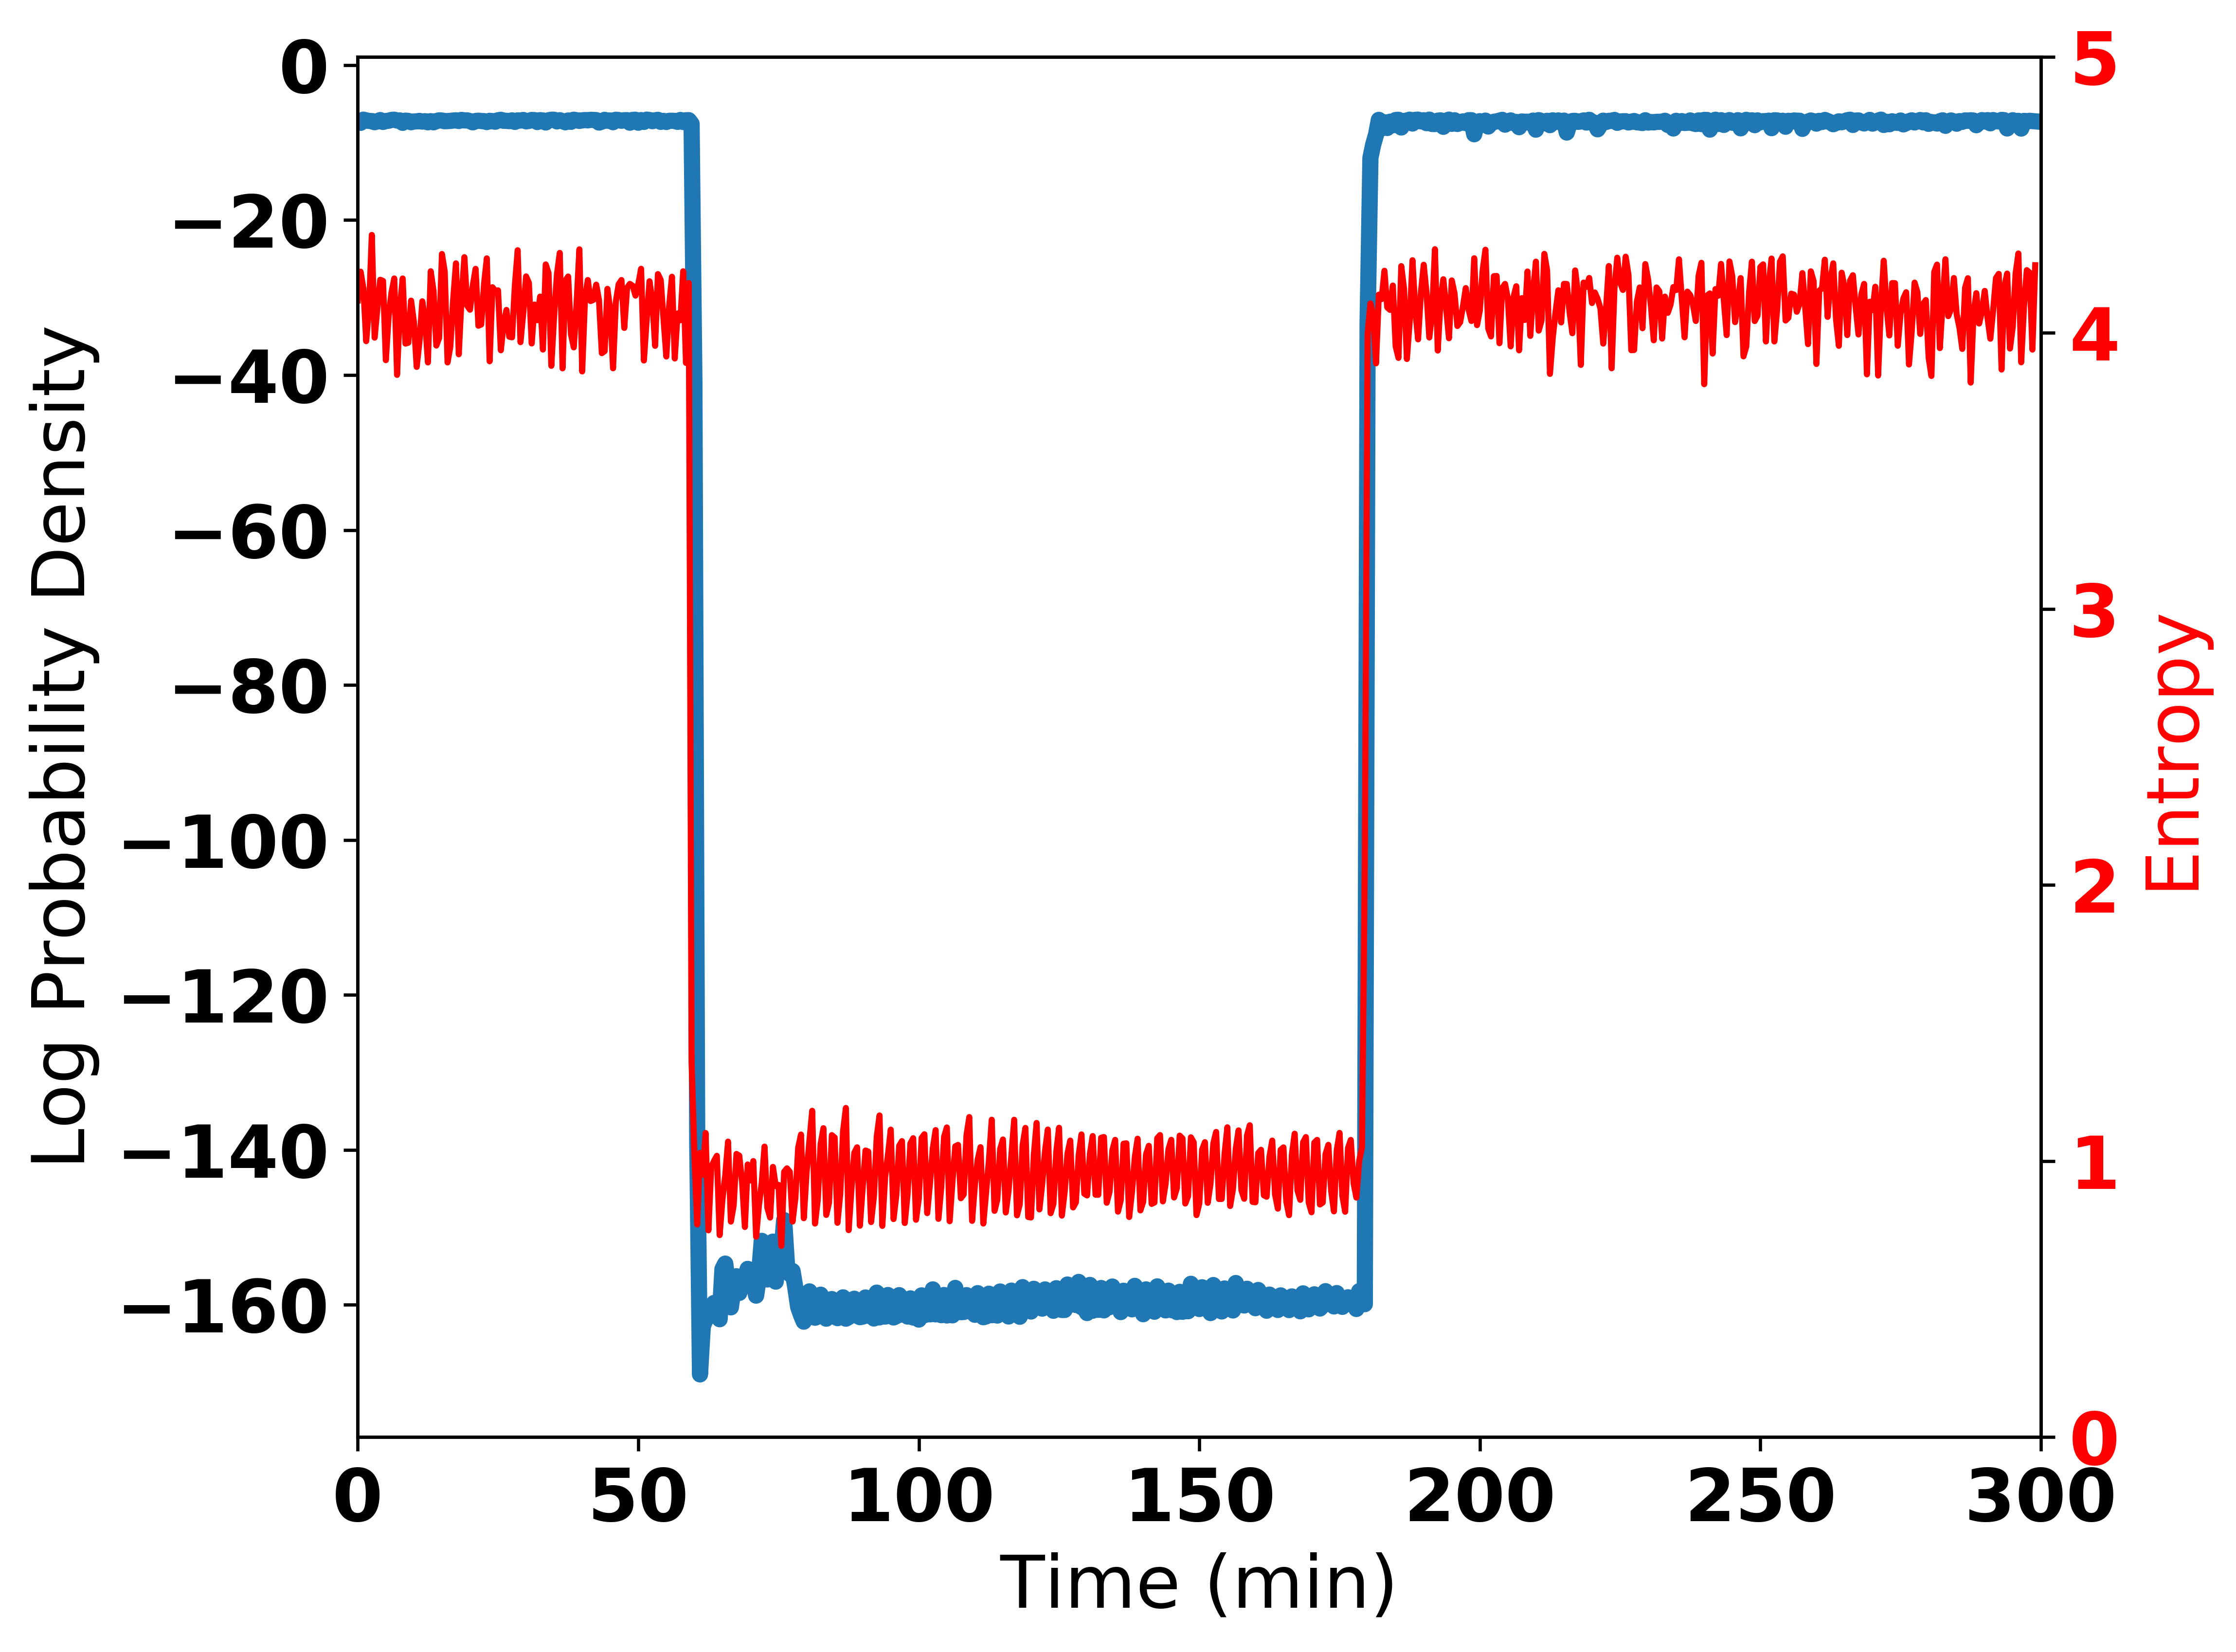

In [125]:
fig = plt.figure(num=None, figsize=(8, 6), dpi=600, facecolor='w', edgecolor='k')
ax1 = fig.add_subplot(111)
ax1.plot(time, np.log10(mvn.pdf(errors_p)), linewidth=4.0)
ax1.set_ylabel('Log Probability Density')
ax1.set_xlabel('Time (min)')
ax2 = ax1.twinx()
ax2.plot(time, entropy, 'r-')
ax2.set_ylabel('Entropy', color='r')
ax2.set_ylim([0, 5])
ax2.set_xlim([0, 300])

for tl in ax2.get_yticklabels():
    tl.set_color('r')
plt.tight_layout()
plt.savefig('Data/Infocom/combined.png')
plt.show()